<h1><center>STAT/CSE 416 Section 6: Review and K-NN</center></h1>
<center><b>Section:</b>AA/AB BA/BB</center>
<center><b>Instructor:</b>Emilija Perković</center>
<center><b>TA:</b>Octavian-Vlad Murad</center>
<center><b>Date:</b>February 16, 2023</center>

<center><b>Authors</b>: Previous 416 TAs. Modifications: Octavian-Vlad Murad</center>

# In the beginning...

there was data. Probably about dinosaurs because they were here first.

<div>
<img src="https://static01.nyt.com/images/2020/04/07/science/26OBS-RAPTOR1/26TB-RAPTOR1-superJumbo.jpg" width="400"/>
</div><sup><sub>Image Source: New York Times (https://www.nytimes.com/2020/03/26/science/raptor-fossil-dinosaurs.html)</sup></sub>

|  Name |    Species    |    Diet   | Weight | Length | Spikes | Sex | Clutch Size | ... |
|:-----:|:-------------:|:---------:|:------:|:------:|:------:|:---:|:-----------:|:---:|
| Terry | Tyrannosaurus | Carnivore |  12.1t |  11.9m |   No   |  M  |      NA     | ... |
| Danny |   Diplodocus  | Herbivore |  13.1t |  32.2m |   No   |  F  |      3      | ... |
| Stacy |  Stegosaurus  | Herbivore |  6.8t  |  8.7m  |   Yes  |  F  |      7      | ... |
| Timmy |  Triceratops  | Herbivore |  9.3t  |  8.2m  |   Yes  |  M  |      NA     | ... |
|  ...  |      ...      |    ...    |   ...  |   ...  |   ...  | ... |     ...     | ... |

</div><sup><sub>Data Source: Like 20 minutes of wikipedia research and a lot of wild speculation.</sup></sub>

Thus far we have focused on two different general data analysis approaches;


## Regression

|  Name |    Species    |    Diet   | Weight | Length | Spikes | Sex | Clutch Size | ... |
|:-----:|:-------------:|:---------:|:------:|:------:|:------:|:---:|:-----------:|:---:|
| Terry | Tyrannosaurus | Carnivore |  **12.1t** |  **11.9m** |   No   |  M  |      NA     | ... |
| Danny |   Diplodocus  | Herbivore |  **13.1t** |  **32.2m** |   No   |  F  |      3      | ... |
| Stacy |  Stegosaurus  | Herbivore |  **6.8t**  |  **8.7m**  |   Yes  |  F  |      7      | ... |
| Timmy |  Triceratops  | Herbivore |  **9.3t**  |  **8.2m**  |   Yes  |  M  |      NA     | ... |
|  ...  |      ...      |    ...    |   ...  |    ...    |   ...  | ... |     ...     | ... |

The problem of regression deals with using covariates to estimate a specific (continuous) quantity (e.g. Length or Weight). Given a set of covariates $X$ (Diet, Sex, Weight or Length, etc), we attempt to find a model $G$ that minimizes error between the estimated quantity $\hat{Y}=G(X)$ and the true observed $Y$.

## Classification


|  Name |    Species    |    Diet   | Weight | Length | Spikes | Sex | Clutch Size | ... |
|:-----:|:-------------:|:---------:|:------:|:------:|:------:|:---:|:-----------:|:---:|
| Terry | **Tyrannosaurus** | **Carnivore** |  12.1t |  11.9m |   **No**   |  **M**  |      NA     | ... |
| Danny |   **Diplodocus**  | **Herbivore** |  13.1t |  32.2m |   **No**   |  **F**  |      3      | ... |
| Stacy |  **Stegosaurus**  | **Herbivore** |  6.8t  |  8.7m  |   **Yes**  |  **F**  |      7      | ... |
| Timmy |  **Triceratops**  | **Herbivore** |  9.3t  |  8.2m  |   **Yes**  |  **M**  |      NA     | ... |
|  ...  |      ...      |    ...    |   ...  |    ...    |   ...  | ... |     ...     | ... |

The problem of classification deals with using covariates to estimate a specific classes (e.g. Species, Diet, Spike-havingness). Given a set of covariates $X$, we attempt to find a model that maximizes the probability of $P(\hat{Y}=y|X).$

# Methods for Regression

We will first consider the task of regression, using the dinosaur clutch survival rate data collected by Dr. Emmett Brown. In this regression task, we want to find a model that closely predicts *Clutch Survival Rate* $Y$ from the *Average Nest Temperature* $X$. 

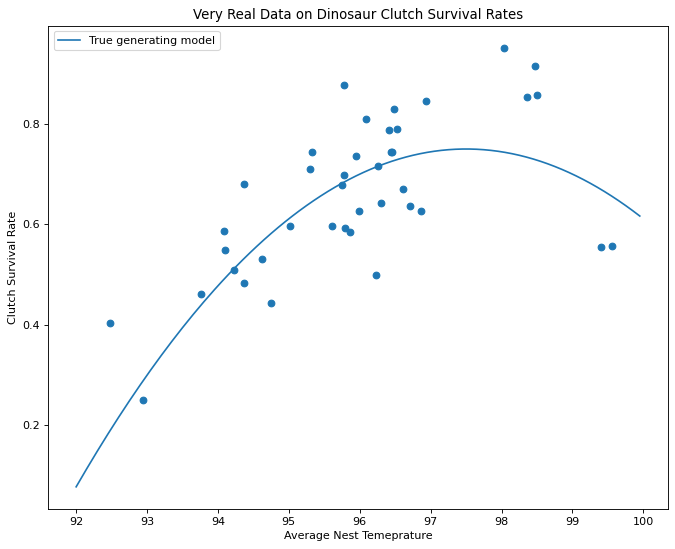

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(101)

reg_x=np.random.normal(95.5, 1.5, 40)
reg_y=-(1/45)*reg_x**2+(13/3)*reg_x-210.5+np.random.normal(0,0.1,(40))
reg_x_true=np.arange(92,100,.05)
a=-1/45; b=13/3; c=-210.5
reg_y_true=a*reg_x_true**2+b*reg_x_true+c

fig,ax=plt.subplots(figsize=(10, 8), dpi=80)
ax.scatter(reg_x,reg_y)
ax.set_ylabel("Clutch Survival Rate")
ax.set_xlabel("Average Nest Temeprature")
ax.set_title("Very Real Data on Dinosaur Clutch Survival Rates")
plt.plot(reg_x_true,reg_y_true,label="True generating model")
plt.legend()
plt.show()

## Linear Regression

Our first approach to fitting regression models is simple linear regression. Here we attempt to fit a linear relationship between our output $Y$ and our input $X$. Mathematically, we want to find $\hat{\beta} \in \mathbb{R}^{n + 1}$ such that :

<br>

$$\hat{\beta} = \arg\min_\beta\sum^N_{i = 1} (Y_i-\hat Y_i)^2$$
$$\text{where } \hat Y_i=\beta_0+\beta_1 X^1_i+ \beta_2 X^2_i+ \dots + \beta_nX^n_i
\text{ and where we have $N$ training samples}: X_i = \begin{bmatrix} X^1_i \\ X^2_i \\ \vdots \\ X^n_i\end{bmatrix} \in \mathbb{R}^n \text{ and } Y_i \in \mathbb{R}$$

<br>

The quality metric that we aim to minimize is called the <b>Residual Sum of Squares(RSS)</b>:

<br>
$$RSS(\beta) = \sum^N_{i = 1} (Y_i-\hat Y_i)^2 $$
<br>

The solution can be computed either via **gradient descent** or using the **normal equation**:

<br>

$$\hat{\beta} = (X^TX)^{-1}X^Ty
\text{ where } X = \begin{bmatrix} 1 & --X_1-- \\ 1 & --X_2-- \\ \vdots & \vdots \\ 1 & --X_n-- \end{bmatrix} \text { and } y = \begin{bmatrix} Y_1 \\ Y_2 \\ \vdots \\ Y_N \end{bmatrix}$$

<br>

The model complexity grows with the number of features we use.

### Advantages:

* No hyperparameters.
* Interpretable: $\beta_i$ gives us an idea of the relationship between $X_i$ and $Y$.
* Quick to train and predict.
* Has a closed form solution.

### Disadvantages:

* Requires manual feature selection to avoid overfitting.
* Assumes a linear relationship between target $Y$ and features $X$ which often times is too simplistic.
* Assumes Gaussian noise with 0 mean.

### Example

Using: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

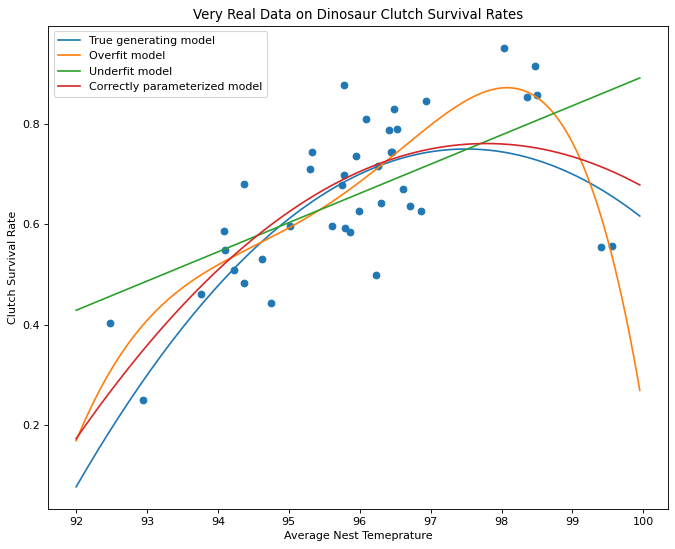

Coefficients:  [[ 3.43430638 -0.01756088]] [-167.14725925]
Truth:  4.333333333333333 -0.022222222222222223 -210.5


In [2]:
from sklearn import linear_model

#First we create some features by taking exponential powers of X
#Forgive my terrible use of Pandas, I've always preferred grizzlies 
pd_reg_y=pd.DataFrame(reg_y)
pd_reg_x=pd.DataFrame([reg_x**1, reg_x**2, reg_x**3, reg_x**4, reg_x**5, 
                       reg_x**6, reg_x**7, reg_x**8, reg_x**9, reg_x**10]).T
pd_reg_x.columns=['1','2','3','4','5','6','7','8','9','10']
pd_reg_x_predict=pd.DataFrame([reg_x_true**1, reg_x_true**2, reg_x_true**3, reg_x_true**4, reg_x_true**5, 
                               reg_x_true**6, reg_x_true**7, reg_x_true**8, reg_x_true**9, reg_x_true**10]).T  
pd_reg_x_predict.columns=['1','2','3','4','5','6','7','8','9','10']

#Then we will fit two models, one proper model, and one overfit model
lin_reg=linear_model.LinearRegression()
lin_reg.fit(pd_reg_x[['1','2']],pd_reg_y) #We will fit a 'correct' model with only X^1, and X^2 terms                 
lin_reg_overfit=linear_model.LinearRegression()
lin_reg_overfit.fit(pd_reg_x,pd_reg_y) #We will also overfit a model with all X^i, i in [0,10]   
lin_reg_underfit=linear_model.LinearRegression()
lin_reg_underfit.fit(pd_reg_x[['1']],pd_reg_y) #We will also under fit a model which uses only X

#Plot two models and truth
fig,ax=plt.subplots(figsize=(10, 8), dpi=80)
ax.scatter(reg_x,reg_y)
ax.set_ylabel("Clutch Survival Rate")
ax.set_xlabel("Average Nest Temeprature")
ax.set_title("Very Real Data on Dinosaur Clutch Survival Rates")
plt.plot(reg_x_true,reg_y_true,label="True generating model")
plt.plot(reg_x_true,lin_reg_overfit.predict(pd_reg_x_predict),label="Overfit model")
plt.plot(reg_x_true,lin_reg_underfit.predict(pd_reg_x_predict[['1']]),label="Underfit model")
plt.plot(reg_x_true,lin_reg.predict(pd_reg_x_predict[['1','2']]),label="Correctly parameterized model")
plt.legend()
plt.show()
print("Coefficients: ",lin_reg.coef_,lin_reg.intercept_)
print("Truth: ",b,a,c)

### Questions:
- What behaviour do we expect from the Underfit Model(green line) and from the Overfit Model(orange line) as the number of data points increases?

### Answers:
- Not much will happen to the Underfit Model. This model has high bias and more data cannot fix that. The Overfit Model will get arbitrarily close to the True Model as collecting more data helps reduce variance.

## Ridge Regression

We can build on linear regression by introducing a penalty on the magnitude of our model coefficients. For *Ridge Regression*, the regularization penality is proportional to the the squared **Eucledian norm/L2 norm** of the vector $\hat\beta$. Mathematically, we want to find $\hat{\beta} \in \mathbb{R}^{n + 1}$ such that :

<br>

$$\hat{\beta} = \arg\min_\beta\sum^N_{i = 1} (Y_i-\hat Y_i)^2 + \lambda \|\beta\|_2^2$$
$$\text{where } \hat Y_i=\beta_0+\beta_1 X^1_i+ \beta_2 X^2_i+ \dots + \beta_nX^n_i
\text{ and where we have $N$ training samples}: X_i = \begin{bmatrix} X^1_i \\ X^2_i \\ \vdots \\ X^n_i\end{bmatrix} \in \mathbb{R}^n \text{ and } Y_i \in \mathbb{R} \text{ and } \lambda \in [0, \infty]$$

<br>

The parameter is used to balance how much weight we put on the **regularization term**, $\|\beta\|_2^2$, relative to the **goodness of fit term**, the RSS. We have the following relationships between $\lambda$ and model complexity:

<br>

$$\uparrow \lambda \Rightarrow \text{ } \downarrow \text{ model complexity and } \downarrow \text{ magnitude of coefficients $\beta_i$} $$ 
$$\downarrow \lambda \Rightarrow \text{ } \uparrow \text{ model complexity and } \uparrow \text{ magnitude of coefficients $\beta_i$} $$

<br>

Using the picture below, we can get a better idea of how the regularization term influences model complexity. The red ball around the origin represents the region of space where the solution $\hat{\beta}$ can lie. For each value of $\lambda$ we obtain one such ball around the origin. The larger the value of $\lambda$, the smaller the size of the ball, and the more we force our solution to be closer to the origin. When $\lambda = \infty$, the ball is collapsed to the origin and the only allowed solution is 0. The smaller the value of $\lambda$, the larger the size the ball, and the more unconstrained our solution will be. When $\lambda = 0$, the solution is unconstrained and the ball will be the whole space.

<div>
<img src="https://allmodelsarewrong.github.io/images/penalized/ridge-constraint3.svg" alt="Error contours with constraint region" width="400">
</div><sup><sub>Image Source: https://allmodelsarewrong.github.io/</sup></sub>

The solution can be computed either via gradient descent or using the closed form solution:
$$\hat{\beta} = (X^TX + \lambda I)^{-1}X^Ty
\text{ where } X = \begin{bmatrix} 1 & --X_1-- \\ 1 & --X_2-- \\ \vdots & \vdots \\ 1 & --X_n-- \end{bmatrix} \text { , } y = \begin{bmatrix} Y_1 \\ Y_2 \\ \vdots \\ Y_N \end{bmatrix} \text{ , and $I$ is the identity matrix} $$

### Advantages

* Interpretable: $\beta_i$ gives us an idea of the relationship between $X_i$ and $Y$.
* Quick to train and predict.
* Has a closed form solution.
* Robust to overfitting (with good selection of $\lambda$).

### Disadvantages

* Requires manual feature selection to avoid overfitting.
* Assumes a linear relationship between target $Y$ and features $X$ which often times is too simplistic.
* Assumes Gaussian noise with 0 mean.
* Requires selecting hyperparameter $\lambda$, ie using validation data.

### Example

Using: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

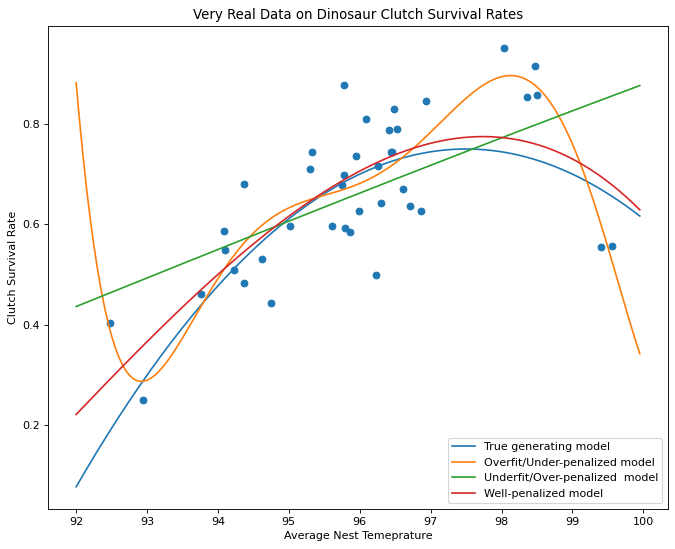

Well penalized min/max coef:  -2.3373194320394752   1.3782032468544931
Over penalized min/max coef:  -0.01770517233539704   0.03475256937122915
Under penalized min/max coef:  -28686370.873065762   19089421.141978554


In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X=pd_reg_x)

#Then we will fit two models, one proper model, and one overfit model
ridge_reg=linear_model.Ridge(alpha=.0005,random_state=1) 
ridge_reg.fit(scaler.transform(pd_reg_x), pd_reg_y)
ridge_reg_overpen=linear_model.Ridge(alpha=5,random_state=1) 
ridge_reg_overpen.fit(scaler.transform(pd_reg_x), pd_reg_y)
ridge_reg_underpen=linear_model.Ridge(alpha=1e-20,random_state=1) 
ridge_reg_underpen.fit(scaler.transform(pd_reg_x), pd_reg_y)

#Plot all 3 models and truth
fig,ax=plt.subplots(figsize=(10, 8), dpi=80)
ax.scatter(reg_x,reg_y)
ax.set_ylabel("Clutch Survival Rate")
ax.set_xlabel("Average Nest Temeprature")
ax.set_title("Very Real Data on Dinosaur Clutch Survival Rates")
plt.plot(reg_x_true,reg_y_true,label="True generating model")
plt.plot(reg_x_true,ridge_reg_underpen.predict(scaler.transform(pd_reg_x_predict)),label="Overfit/Under-penalized model")
plt.plot(reg_x_true,ridge_reg_overpen.predict(scaler.transform(pd_reg_x_predict)),label="Underfit/Over-penalized  model")
plt.plot(reg_x_true,ridge_reg.predict(scaler.transform(pd_reg_x_predict)),label="Well-penalized model")
plt.legend()
plt.show()
print("Well penalized min/max coef: ",np.min(ridge_reg.coef_)," ",np.max(ridge_reg.coef_))
print("Over penalized min/max coef: ",np.min(ridge_reg_overpen.coef_)," ",np.max(ridge_reg_overpen.coef_))
print("Under penalized min/max coef: ",np.min(ridge_reg_underpen.coef_)," ",np.max(ridge_reg_underpen.coef_))

### Questions
* Do we apply regularization to the intercept $\beta_0$?
* Why is it important to scale features when using ridge regression?

### Answers
* No, unless we also subtract the mean from the labels $Y$. The reason is that if we were to penalize the intercept, then we wouldn't be able to model responses $Y$ which are not centered at 0 because we would force the $\beta_0$ to be close to 0.
* Because we want to make sure that we penalize the magnitude of each coefficient $\beta_i$ equally and without being influenced by the scale of the feature $X_i$ it corresponds to. 

## Lasso Regression

In the same vein as Ridge Regression, *Lasso Regression* seeks to penalize the magnitude of the coefficients proportionally to the squared **Manhattan norm/L1 norm** of the vector $\hat\beta$. Mathematically, we want to find $\hat{\beta} \in \mathbb{R}^{n + 1}$ such that :

<br>

$$\hat{\beta} = \arg\min_\beta\sum^N_{i = 1} (Y_i-\hat Y_i)^2 + \lambda \|\beta\|_1^2$$
$$\text{where } \hat Y_i=\beta_0+\beta_1 X^1_i+ \beta_2 X^2_i+ \dots + \beta_nX^n_i
\text{ and where we have $N$ training samples}: X_i = \begin{bmatrix} X^1_i \\ X^2_i \\ \vdots \\ X^n_i\end{bmatrix} \in \mathbb{R}^n \text{ and } Y_i \in \mathbb{R} \text{ and } \lambda \in [0, \infty]$$

<br>

The regularization term of the Lasso and $\lambda$ influence the complexity of the model in about the same way as they do for Ridge Regression. The main difference is that Lasso produces **sparse solutions**. That is, Lasso Regression will output vectors $\beta$ which have hard 0s, as opposed to Ridge Regression where the coefficients will never be exactly 0. The intuition for this behavior is the following: The red rhombus(mathematically, also called a ball) around the origin represents the region of space where the solution $\beta$ can lie, in the exact same way as it did for Ridge Regression. However, because of its pointy shape, it is more likely that the RSS error surface(represented in blue) will intersect the rhombus at its corners, which correspond to soultions having 0s. This intuition can be extended to higher dimensions. For example, in 3D, corners and edges of the 3D equivalent of a rhombus will be solutions with 0s.

<div>
<img src="https://allmodelsarewrong.github.io/images/penalized/lasso-constraint1.svg" alt="Error contours with constraint region" width="400">
</div><sup><sub>Image Source: https://allmodelsarewrong.github.io/</sup></sub>

As opposed to Ridge Regression, Lasso Regression doesn't have a closed form soultion nor can we use gradient descent because the L1 norm is not differentiable. However, it turns out that the problem is not very difficult to optimize(for those interested, FISTA is the name of the method generally used and relies on something call proximal gradient descent).

### Advantages

* Interpretable: $\beta_i$ gives us an idea of the relationship between $X_i$ and $Y$.
* Quick to train and predict.
* Robust to overfitting (with good selection of $\lambda$).
* Feature selection via driving parameters to 0. (LASSO stands for least absolute shrinkage and selection operator - feature selection is literally in the name!).

### Disadvantages

* Assumes a linear relationship between target $Y$ and features $X$.
* Assumes noise with 0 mean.
* Slower to fit due to the non-differentiability of the L1 norm.
* Requires selecting hyperparameter $\lambda$, ie using validation data

### Example

Using: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

/home/ovmurad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.911e-02, tolerance: 9.039e-05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


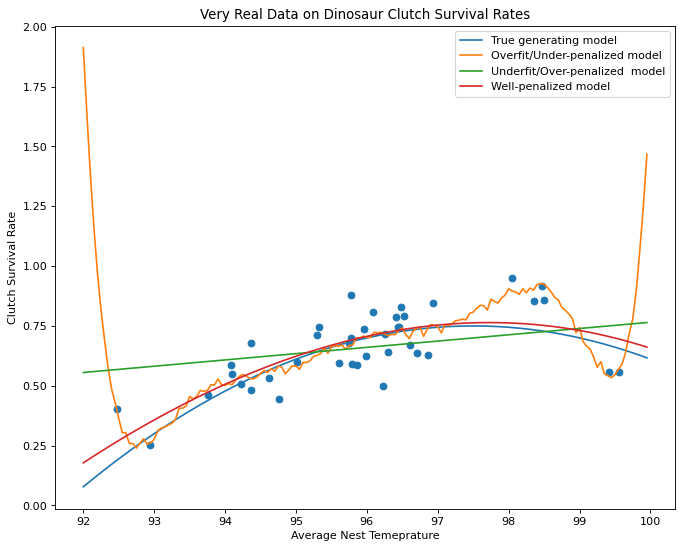

Well penalized min/max coef:  -0.13761408979157547   1.0536714170547294
Over penalized min/max coef:  0.0   0.041184401936205525
Under penalized min/max coef:  -11956214090350.701   10079739513601.688


In [4]:
#Then we will fit two models, one proper model, and one overfit model
lasso_reg_underpen = linear_model.LinearRegression() #I was unable to underpenalize!
lasso_reg_underpen.fit(scaler.transform(pd_reg_x), pd_reg_y)
lasso_reg=linear_model.Lasso(alpha=.00005,random_state=1) 
lasso_reg.fit(scaler.transform(pd_reg_x),pd_reg_y)
lasso_reg_overpen=linear_model.Lasso(alpha=0.05,random_state=1) 
lasso_reg_overpen.fit(scaler.transform(pd_reg_x),pd_reg_y)

#Plot 2 models and truth
fig,ax=plt.subplots(figsize=(10, 8), dpi=80)
ax.scatter(reg_x,reg_y)
ax.set_ylabel("Clutch Survival Rate")
ax.set_xlabel("Average Nest Temeprature")
ax.set_title("Very Real Data on Dinosaur Clutch Survival Rates")
plt.plot(reg_x_true,reg_y_true,label="True generating model")
plt.plot(reg_x_true,lasso_reg_underpen.predict(scaler.transform(pd_reg_x_predict)),label="Overfit/Under-penalized model")
plt.plot(reg_x_true,lasso_reg_overpen.predict(scaler.transform(pd_reg_x_predict)),label="Underfit/Over-penalized  model")
plt.plot(reg_x_true,lasso_reg.predict(scaler.transform(pd_reg_x_predict)),label="Well-penalized model")
plt.legend()
plt.show()
print("Well penalized min/max coef: ",np.min(lasso_reg.coef_)," ",np.max(lasso_reg.coef_))
print("Over penalized min/max coef: ",np.min(lasso_reg_overpen.coef_)," ",np.max(lasso_reg_overpen.coef_))
print("Under penalized min/max coef: ",np.min(lasso_reg_underpen.coef_)," ",np.max(lasso_reg_underpen.coef_))

### Questions
* How can we use Lasso for feature selection?

### Answers

* We first run Lasso and obtain a solution $\beta$ which has a bunch of hard 0s. We remove those features from the data and then trained a vanilla/unregularized linear regression model using the modified data.

# Methods for Classification

We now move to the problem of classification, again using data provided by the eminent Dr. Brown. 

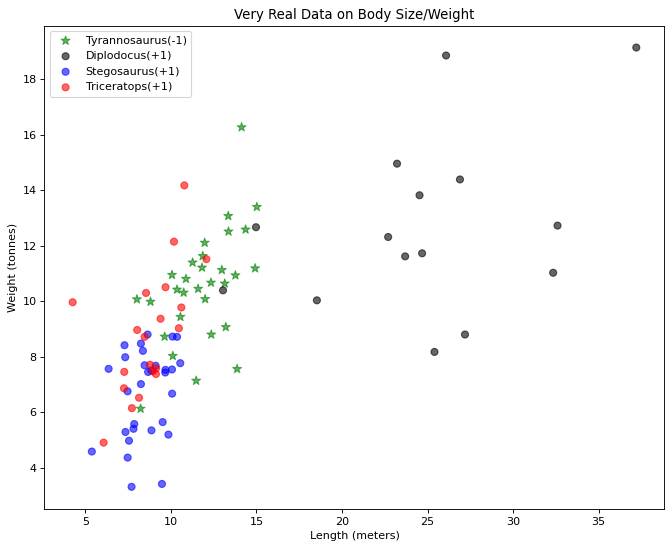

In [5]:
np.random.seed(10)
Tyran={'Wmean':11,'Wstd':2,  'Lmean':12,'Lstd':2.2,'Spikes':0,'Herb':0,'n':30,'plotcol':'green'}
Diplo={'Wmean':13,'Wstd':2.5,'Lmean':25,'Lstd':6.5,'Spikes':0,'Herb':1,'n':15,'plotcol':'black'}
Stego={'Wmean':7, 'Wstd':1.5,'Lmean':9, 'Lstd':1.5,'Spikes':1,'Herb':1,'n':30,'plotcol':'blue'}
Trice={'Wmean':9, 'Wstd':2,  'Lmean':9, 'Lstd':1.8,'Spikes':1,'Herb':1,'n':20,'plotcol':'red'}
def sampleDino(dinodict):
    sd1=dinodict['Wstd']
    sd2=dinodict['Lstd']
    cov=np.array([[sd1**2,.4*sd1*sd2],[.4*sd1*sd2,sd2**2]])
    wandl=np.random.multivariate_normal([dinodict['Wmean'],dinodict['Lmean']],cov,size=dinodict['n'])
    out_pd=pd.DataFrame({'Weight':wandl[:,0],'Length':wandl[:,1],'Spikes':dinodict['Spikes'],'Herb':dinodict['Herb'],'pcol':dinodict['plotcol']})
    return(out_pd)

d1=sampleDino(Tyran)
d2=sampleDino(Diplo)
d3=sampleDino(Stego)
d4=sampleDino(Trice)
cat_data=pd.concat([d1,d2,d3,d4])

fig,ax=plt.subplots(figsize=(10, 8), dpi=80)
a1=plt.scatter(d1['Length'],d1['Weight'],c=d1['pcol'],marker='*', s=70, alpha=0.6)
a2=plt.scatter(d2['Length'],d2['Weight'],c=d2['pcol'],marker='o', s=40, alpha=0.6)
a3=plt.scatter(d3['Length'],d3['Weight'],c=d3['pcol'],marker='o', s=40, alpha=0.6)
a4=plt.scatter(d4['Length'],d4['Weight'],c=d4['pcol'],marker='o', s=40, alpha=0.6)
ax.set_ylabel("Weight (tonnes)")
ax.set_xlabel("Length (meters)")
ax.set_title("Very Real Data on Body Size/Weight")
plt.legend(('Tyrannosaurus(-1)','Diplodocus(+1)','Stegosaurus(+1)','Triceratops(+1)'))
plt.show()

We will attempt to find models that can classify the carivores (Tyrannosaurus) vs herbivores (Diplodocus, Stegosaurus, Triceratops) using only weight, length, and spike-havingness (represented by the spikiness of the points in the plot).

## Assessing Classification

Unlike in regression where we have a mathematical error we are trying to minimize, in classification we aim to maximize the probability of each data point being correctly classified. To this end we define four distinct types of responses, based on the true class and predicted class of a data point, as well as the all important **Confusion Matrix**:

|               |     **Predicted Positive** |     **Predicted Negative**     | 
|:--------------------------:|:--------------------------:|:--------------:|
| **Label Positive** |   True Positive [TP] (Correct)  | False Negative [FN] (Incorrect) |
| **Label Negative** | False Positive [FP] (Incorrect) |   True Negative [TN] (Correct) |

**True Positives (TP)** and **True Negatives (TN)** are correctly classified classes, where we associate one class as a baseline. In our case herbivores (TP) are the base 'positive' class with $herb=1$. **False negatives (FN)** and **False Positives (FP)** represent unique errors where, in our case we are classifying an herbivore as a carnivore (FN) or a carnivore as an herbivore (FP). 

Because these mistakes may have different consequences (especially for Dr. Brown), we may prefer a model that errs one way or another. Consult the notes for more discussion on this topic, and for different metrics for measuring classification error (such as: **Precision**, **Recall**, **ROC curves**, **Precision-Recall curves**, **F1-score**).

Note that we can expand this to more than 2 classes, with a 'confusion matrix' showing each missclassification by truth/predicted.

## Logistic Regression

*Logistic regression* builds on the concept of linear regression, seeking to find a linear model that takes on negative values of the **score**$_{\beta}(X)$ = $\beta^T X$ for the negative class($Y = -1$), and positive values of the score for the positive class($Y = +1$). We pass the score through the **sigmoid function**, $\sigma(x) = \frac{1}{1+e^{-x}}$, to produce a probability for membership in each class given some input $X$. That is:

<br>

$$P(Y=1|X; \beta) = \sigma(score_\beta(X)) = \frac{1}{1+e^{-\beta X}}$$

and 

$$P(Y=-1|X; \beta) = 1 - \sigma(score_\beta(X)) = \frac{e^{-\beta X}}{1+e^{-\beta X}}$$

<br>

Mathematically, we want to find $\hat{\beta}$ such that maximizes the **likelihood function** $\mathcal{L}_N(\beta)$. That is:

<br>

$$\hat{\beta} = \arg\max_\beta \mathcal{L}_N(\beta) = \arg\max_\beta \,\,  \prod^N_{i=1} \big[P(Y_i=1|X_i; \beta)I(Y_i=1) +P(Y_i=-1|X_i; \beta)I(Y_i=-1)\big]$$

<br>

$$\text{where we have $N$ training samples}: X_i = \begin{bmatrix} X^1_i \\ X^2_i \\ \vdots \\ X^n_i\end{bmatrix} \in \mathbb{R}^n \text{ and } Y_i \in \{-1, 1 \}$$

The result $\hat{\beta}$ obtained by maximizing the likelihood function is called the **maximum likelihood estimate(MLE)**. Intuitively, the MLE represents the value of the parameters which maximize the probability of observing the training data under our linear model.

Logistic Regression does not have a closed-form solution and is trained via **gradient ascent**.

### Advantages

* Interpretable: $\beta_i$ gives us an idea of the relationship between $X_i$ and $Y$.
* Quick to train and predict.
* Can use Ridge or Lasso regularization to prevent overfitting, as well as Lasso for feature selection.

### Disadvantages

* Assumes a linear relationship between target $Y$ and features $X$.
* Assumes classes are linearly separable.
* When using regularization, it requires selecting hyperparameter $\lambda$, ie using validation data.

### Example

Using: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

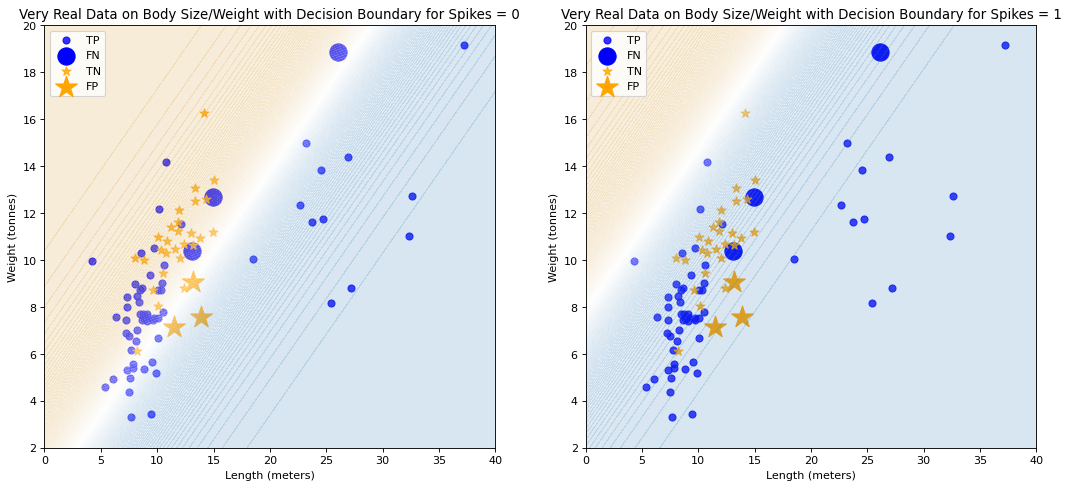

TP: 62  TN: 27  FP: 3  FN: 3
Beta: [ 0.31978012 -0.46405989  3.63977614]


In [6]:
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom', 
                                             [(0, '#D89F39'),
                                              (0.5, '#FFFFFF'),
                                              (1, '#3A81BA')])

logreg_cat=linear_model.LogisticRegression(random_state=1, fit_intercept=False)
logreg_cat.fit(cat_data[['Length','Weight','Spikes']],cat_data['Herb'])
logreg_pred=logreg_cat.predict(cat_data[['Length','Weight','Spikes']])
mle_estimate = logreg_cat.coef_[0]

TP=(logreg_pred==1)*(np.array(cat_data['Herb']==1))
TN=(logreg_pred==0)*(np.array(cat_data['Herb']==0))
FP=(logreg_pred==1)*(np.array(cat_data['Herb']==0))
FN=(logreg_pred==0)*(np.array(cat_data['Herb']==1))

xs = np.linspace(0, 40, 200)
ys = np.linspace(2, 20, 200)

xx, yy = np.meshgrid(xs, ys)

fig,ax=plt.subplots(1, 2, figsize=(16, 7), dpi=80)

a1=ax[0].scatter(cat_data[TP]['Length'],cat_data[TP]['Weight'],c='blue',marker='o', s=40, alpha=0.8)
a1=ax[0].scatter(cat_data[FN]['Length'],cat_data[FN]['Weight'],c='blue',marker='o', s=240, alpha=1.0)
a1=ax[0].scatter(cat_data[TN]['Length'],cat_data[TN]['Weight'],c='orange',marker='*', s=70, alpha=0.8)
a1=ax[0].scatter(cat_data[FP]['Length'],cat_data[FP]['Weight'],c='orange',marker='*', s=420, alpha=1.0)

score = xx.ravel() * mle_estimate[0] + yy.ravel() * mle_estimate[1] + 0 * mle_estimate[2]
probs = 1.0/(1.0 + np.exp(-score))
a1=ax[0].contourf(xx, yy, probs.reshape(xx.shape), cmap=cmap, levels=126, alpha=0.2, vmin=0, vmax=1)

ax[0].set_ylabel("Weight (tonnes)")
ax[0].set_xlabel("Length (meters)")
ax[0].set_title("Very Real Data on Body Size/Weight with Decision Boundary for Spikes = 0")
ax[0].legend(('TP','FN','TN','FP'))

a1=ax[1].scatter(cat_data[TP]['Length'],cat_data[TP]['Weight'],c='blue',marker='o', s=40, alpha=0.8)
a1=ax[1].scatter(cat_data[FN]['Length'],cat_data[FN]['Weight'],c='blue',marker='o', s=240, alpha=1.0)
a1=ax[1].scatter(cat_data[TN]['Length'],cat_data[TN]['Weight'],c='orange',marker='*', s=70, alpha=0.8)
a1=ax[1].scatter(cat_data[FP]['Length'],cat_data[FP]['Weight'],c='orange',marker='*', s=420, alpha=1.0)

score = xx.ravel() * mle_estimate[0] + yy.ravel() * mle_estimate[1] + 1 * mle_estimate[2]
probs = 1.0/(1.0 + np.exp(-score))
a1=ax[1].contourf(xx, yy, probs.reshape(xx.shape), cmap=cmap, levels=126, alpha=0.2, vmin=0, vmax=1)

ax[1].set_ylabel("Weight (tonnes)")
ax[1].set_xlabel("Length (meters)")
ax[1].set_title("Very Real Data on Body Size/Weight with Decision Boundary for Spikes = 1")
ax[1].legend(('TP','FN','TN','FP'))

plt.show()

print("TP:",sum(TP)," TN:",sum(TN)," FP:",sum(FP)," FN:",sum(FN))
print("Beta:", mle_estimate)

### Questions
- How can we use the Logistic Regression to obtain non linear decision boundaries?

### Answers
- Although Logisitic Regression is a linear model, the decision boundaries are linear only in the space in which the linear classifier is computed. Thus, if we take our original data $X$ and compute non linear features of it(for example polynomial features) and then apply Logistic Regression to these derived features, the decision boundary in the original space will not be linear.

## Naive Bayes

*Naive Bayes* is a simple probabilistic framework for classifiers. By **Bayes' Rule**, we have that:

$$P(Y=y|X=x) = \frac{P(X=x|Y=y)P(Y=y)}{P(X=x)}$$

Suppose that we only have two labels $Y = \{-1, 1\}$. Then, for classification, we need to compare the values $P(Y=-1|X=x)$ and $P(Y=1|X=x)$ and output the class with the higher conditional probability as our prediction. Since the denominator $P(X=x)$ is the same in both terms and doesn't depend on $Y$, we can restrict our attention to the two numerators $P(X=x|Y=-1)P(Y=-1)$ and $P(X=x|Y=1)P(Y=1)$ and compare them to obtain a prediction. Furthermore, we make the **Naive Bayes assumption** which states that the features of $X$ are conditionally independent given $Y$, meaning that we can decompose the numerators as:
$$P(X=x|Y=-1)P(Y=-1) = \prod_{i=1}^n P(X_i = x_i|Y=-1)P(Y=-1) \text{ and } P(X=x|Y=1)P(Y=1) = \prod_{i=1}^n P(X_i = x_i|Y=1)P(Y=1)$$

Previously discussed models have been **discriminative models** meaning that they only aim to model the conditional probability $P(Y|X)$. In contrast, Naive Bayes is a **generative model** meaning that it aims to model the whole joint probability $P(Y, X)$. 

Each of the probabilities $P(X_i=x_i|Y=y)$ and $P(Y=y)$ are modeled by some paramatrized probability distribution. For example, $P(X_i=x_i|Y=y)$ can be a normal distribution if $X$ is continuous or a Bernoulii distribution if $Y \in \{-1, 1\}$. Usually, $P(Y=y)$ is a categorical distribution. To estimate the parameters of these distributions we use MLE.

### Advantages

* Interpretable - we put specific distributions on $P(X|Y)$ that we can assess.
* Robust to overfitting.
* The Naive Bayes assumption greatly decreases the number of parameters needed. 
* Works very well when the Naive Bayes' assumption is approximately true for the problem at hand.

### Disadvantages

* The Naive Bayes assumption is rarely true in practice.
* Requires distributional assumptions on the data (IE: Gaussian, Binomial, etc)

### No Example...

See: https://scikit-learn.org/stable/modules/naive_bayes.html

## Decision Trees and Random Forests

A *Decision Tree* can be used for either regression or classification, with almost identical application. Intuitively, a *Decision Tree* is just a collection of if/else statements, one for each node, with each statement verifying one of the features of $X$ and picking the branch corresponding to whichever statement evaluates to true. For a data point $X$, we follow the trail of if/else statements starting from the root down to a leaf. Then, the classification or regression is performed by the leaf which stores a very simple classification or regression model. Generally, we use a **majority class classifier** for classification and the mean of the training data that reached the leaf for regression.



The decision tree below looks at the healthiness of humans and dinosaurs (dinosaurs of course sticking to a Jurassic diet - no fast food):

<div>
<img src="https://www.tutorialspoint.com/machine_learning_with_python/images/decision_tree_introduction.jpg" width="500"/>
</div><sup><sub>Image Source: tutorialspoint.com (https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_classification_algorithms_decision_tree.htm)</sup></sub>

Decision Trees are trained using a **greedy algorithm** which recursivelly splits the data at each node in such a way that each split optimizes some quality metric(some examples of often used quality metrics are: **Misclassification Error**, **Entropy**, **Gini Index**). Given a node which we want to split and the data that reached it, we test the quality of each potential split by training the aforementioned simple models at the leaves obtained after the proposed split and by computing the value of the quality metric with the new leaves added.
The splitting stops when a maximum tree depth is reached, or when the number of datapoints at a leaf goes below a certain threshold, or when the improvement in the quality metric is too small. These stopping conditions can be used to prevent overfitting. Another important overfitting prevention strategy is **prunning** which consists of fully growing the tree and then removing nodes that don't offer much improvement of the quality metric.

Trainning a tree is a greedy process, because we always pick the immediate best spit, while the optimal tree might involve some initial splits which are not the best with respect to the quality metric. Thus, it is unlikely that decission trees will find a global optimum. However, finding the global optimum is computationally impractical, so we have to settle for the greddy solution.

Trees are high variance, low bias models. In order to reduce variance, we train **Random Forests** instead of single tree classifiers. A *Random Forest* consists of training an ensemble of trees, each tree being trained on a **bootstrapped** dataset and using a randomly selected subset of the features of the data. These strategies are meant to make the trees in the forest as uncorrelated as possible which can be shown to drastically decrease variance. At prediction time, each tree in the forest classifies or performs regression on the data point and the results are aggregated.

### Advantages

* Trees are interpretable - the entire breakdown and decision process can be seen.
* Simple implementation and prediction. Very easy to use out-of-the-box.
* Random Forests can be trained in parallel and solve many of the problems related to overfiiting that simple tree classifiers have.

### Disadvantages

* Single trees are prone to overfitting and require a lot of hyperparameter tunning
* Tree models don't perform well when there are strong correlations between sets of features(for example images).
* Random Forests are not interpretable.

###  Example - Classification

* Trees: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

/home/ovmurad/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/ovmurad/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


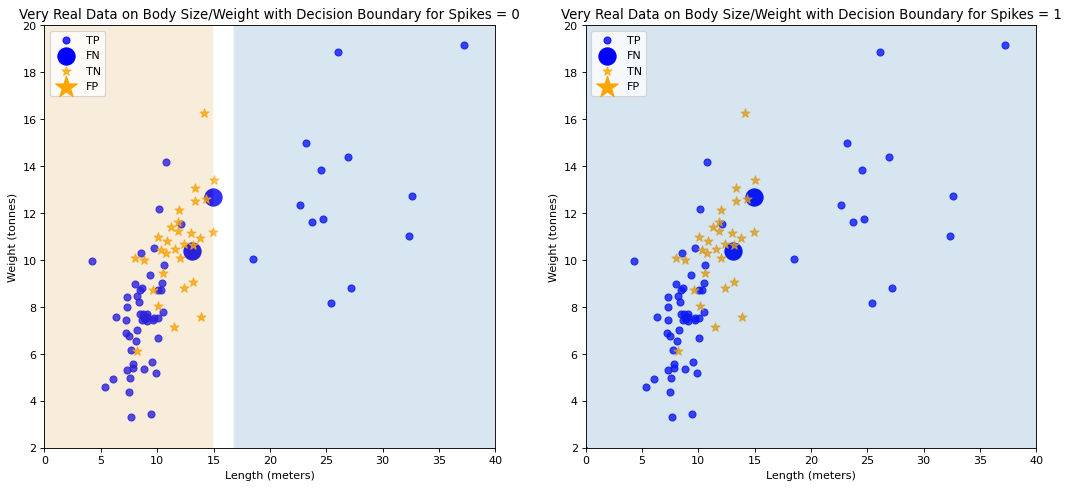

TP: 63  TN: 30  FP: 0  FN: 2


In [7]:
from sklearn.tree import DecisionTreeClassifier

dectree_cat=DecisionTreeClassifier(random_state=1, max_depth=3)
dectree_cat.fit(cat_data[['Length','Weight','Spikes']],cat_data['Herb'])
dectree_pred=dectree_cat.predict(cat_data[['Length','Weight','Spikes']])

TP=(dectree_pred==1)*(np.array(cat_data['Herb']==1))
TN=(dectree_pred==0)*(np.array(cat_data['Herb']==0))
FP=(dectree_pred==1)*(np.array(cat_data['Herb']==0))
FN=(dectree_pred==0)*(np.array(cat_data['Herb']==1))

xs = np.linspace(0, 40, 200)
ys = np.linspace(2, 20, 200)

xx, yy = np.meshgrid(xs, ys)

fig, ax=plt.subplots(1, 2, figsize=(16, 7), dpi=80)

a1=ax[0].scatter(cat_data[TP]['Length'],cat_data[TP]['Weight'],c='blue',marker='o', s=40, alpha=0.8)
a1=ax[0].scatter(cat_data[FN]['Length'],cat_data[FN]['Weight'],c='blue',marker='o', s=240, alpha=1.0)
a1=ax[0].scatter(cat_data[TN]['Length'],cat_data[TN]['Weight'],c='orange',marker='*', s=70, alpha=0.8)
a1=ax[0].scatter(cat_data[FP]['Length'],cat_data[FP]['Weight'],c='orange',marker='*', s=420, alpha=1.0)

probs = dectree_cat.predict_proba(np.stack([xx.ravel(), yy.ravel(), np.repeat(0, xx.size)], axis=1))
a1=ax[0].contourf(xx, yy, probs[:, 1].reshape(xx.shape), cmap=cmap, levels=126, alpha=0.2, vmin=0, vmax=1)

ax[0].set_ylabel("Weight (tonnes)")
ax[0].set_xlabel("Length (meters)")
ax[0].set_title("Very Real Data on Body Size/Weight with Decision Boundary for Spikes = 0")
ax[0].legend(('TP','FN','TN','FP'))

a1=ax[1].scatter(cat_data[TP]['Length'],cat_data[TP]['Weight'],c='blue',marker='o', s=40, alpha=0.8)
a1=ax[1].scatter(cat_data[FN]['Length'],cat_data[FN]['Weight'],c='blue',marker='o', s=240, alpha=1.0)
a1=ax[1].scatter(cat_data[TN]['Length'],cat_data[TN]['Weight'],c='orange',marker='*', s=70, alpha=0.8)
a1=ax[1].scatter(cat_data[FP]['Length'],cat_data[FP]['Weight'],c='orange',marker='*', s=420, alpha=1.0)

probs = dectree_cat.predict_proba(np.stack([xx.ravel(), yy.ravel(), np.repeat(1, xx.size)], axis=1))
probs[0] = 0.99 # trick to get the proper coloring
a1=ax[1].contourf(xx, yy, probs[:, 1].reshape(xx.shape), cmap=cmap, levels=126, alpha=0.2, vmin=0, vmax=1)

ax[1].set_ylabel("Weight (tonnes)")
ax[1].set_xlabel("Length (meters)")
ax[1].set_title("Very Real Data on Body Size/Weight with Decision Boundary for Spikes = 1")
ax[1].legend(('TP','FN','TN','FP'))

plt.show()
print("TP:",sum(TP)," TN:",sum(TN)," FP:",sum(FP)," FN:",sum(FN))

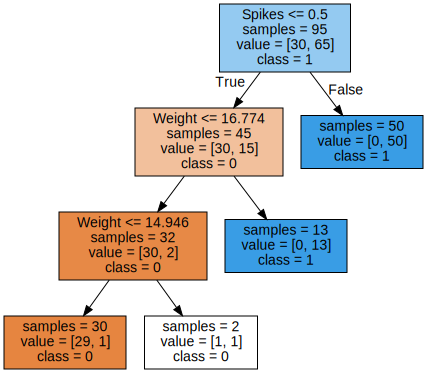

In [8]:
from sklearn import tree

# Hack to fail gracefully if graphviz is not installed
try:
    import graphviz

    def draw_tree(tree_model, features):
        """
        visualizes a Decision Tree
        """
        tree_data = tree.export_graphviz(tree_model, 
                                     impurity=False, 
                                     feature_names=features,
                                     class_names=tree_model.classes_.astype(str),
                                     filled=True,
                                     out_file=None)
        graph = graphviz.Source(tree_data) 
        display(graph)
        
    draw_tree(dectree_cat, ['Weight','Length','Spikes'])
except:
    print('Graphviz not installed.')

## Example - Regression

* Tress: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
* Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

/home/ovmurad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/ovmurad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/ovmurad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/ovmurad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

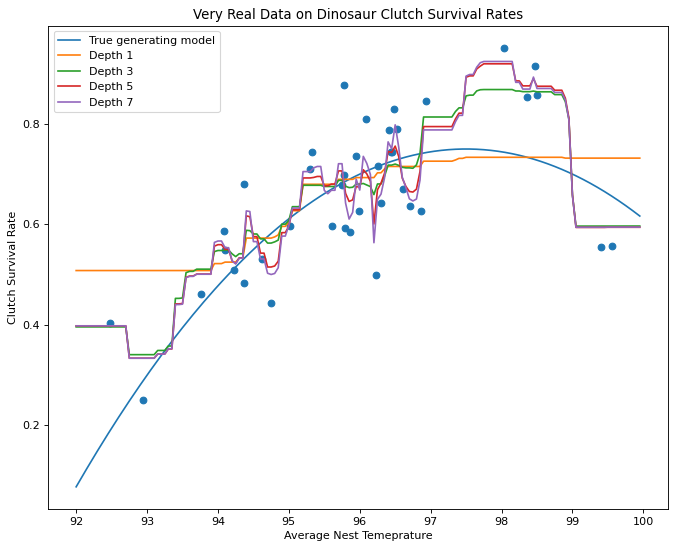

In [9]:
from sklearn.ensemble import RandomForestRegressor

ranfor_reg_1=RandomForestRegressor(max_depth=1, random_state=1)
ranfor_reg_3=RandomForestRegressor(max_depth=3, random_state=1)
ranfor_reg_5=RandomForestRegressor(max_depth=5, random_state=1)
ranfor_reg_7=RandomForestRegressor(max_depth=7, random_state=1)

#We will fit a deep forest and a shallower forest
ranfor_reg_1.fit(pd_reg_x,pd_reg_y)
ranfor_reg_3.fit(pd_reg_x,pd_reg_y)
ranfor_reg_5.fit(pd_reg_x,pd_reg_y)
ranfor_reg_7.fit(pd_reg_x,pd_reg_y)

#Plot 2 models and the truth
fig,ax=plt.subplots(figsize=(10, 8), dpi=80)
ax.scatter(reg_x,reg_y)
ax.set_ylabel("Clutch Survival Rate")
ax.set_xlabel("Average Nest Temeprature")
ax.set_title("Very Real Data on Dinosaur Clutch Survival Rates")
plt.plot(reg_x_true,reg_y_true,label="True generating model")
plt.plot(reg_x_true,ranfor_reg_1.predict(pd_reg_x_predict),label="Depth 1")
plt.plot(reg_x_true,ranfor_reg_3.predict(pd_reg_x_predict),label="Depth 3")
plt.plot(reg_x_true,ranfor_reg_5.predict(pd_reg_x_predict),label="Depth 5")
plt.plot(reg_x_true,ranfor_reg_7.predict(pd_reg_x_predict),label="Depth 7")
plt.legend()
plt.show()

### Questions
- Why isn't there much difference between the Random Forests using depths 3, 5, 7? We would expect to see more squiggly predictors as we increase depth and hence complexity, but that doesn't seem to be the case.
- Why aren't tree based model great for image inputs?

### Answers
* Because bootstrapping and random feature selection decreases variance.
* Visual features(lines, corners, blobs, textures) include multiple pixels in close proximity. Because decision trees make decisions based only on one feature(one pixel in this case), it is very hard for a tree to model these complex interations between sets of pixels.

## AdaBoost

*AdaBoost* is founded on the **boosting** principle: the idea that we can build a strong classifier by combining a bunch of **weak classifiers**(also called **base classifiers**). Base models generally have high bias and low variance and boosting aimes to lower the bias. The AdaBoost algorithm relies on **decision stumps**(trees that only consist of the root) as the base classifiers.

At each step, we train a decision stump using the Misclassification Rate as our quality metric and we add it to the main classifier. The newly trained base classifier is weighted proportionally to its accuracy. Once added to the main classifier, the decision stump is never retrained. A crucial aspect of the algorithm is that each decision stump is trained on the whole data set, but with each data point being weighed depending on how it was classified by previously trained base classifiers. If the weight of a data point is large, then that point was repeatedly misclassified by previously trained decision stumps and since the model is additive in its predictions, it will also be misclassified by the main classifier as a whole. At each training step, the weights get updated. They increase for each data point misclassified by the newly trained classifier and decrease otherwise.

### Advantages

* Usually better at prediction than random forests.
* Very easy to use out-of-the-box.

### Disadvantages

* Not interpretable - weights on stumps give us some idea of stump importance, but little else.
* Requires selecting total number of stumps.
* Ignores relationships between features.
* Requires fitting weights, making parallelization impossible.

### Example - Classification

Classification: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Regression: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

/home/ovmurad/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/ovmurad/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


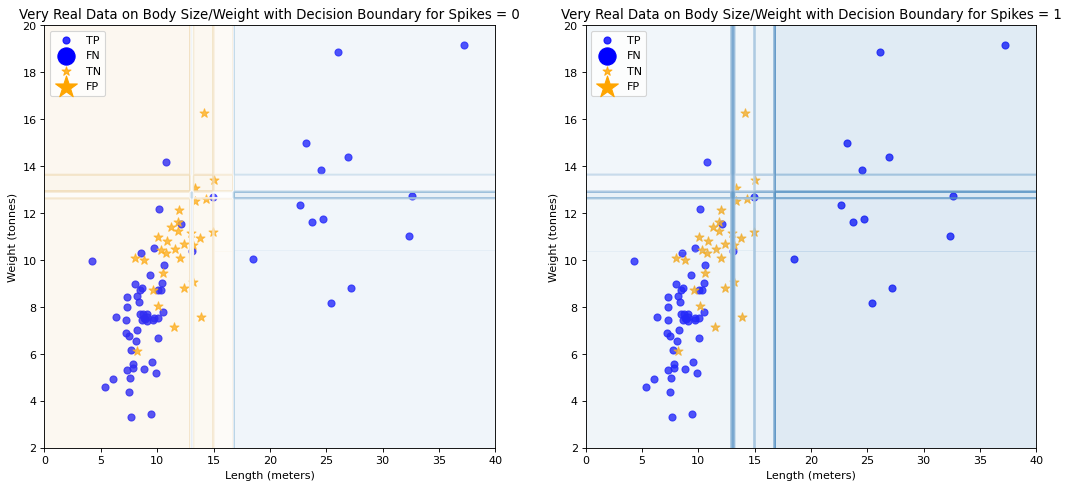

TP: 65  TN: 30  FP: 0  FN: 0


In [10]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_cat=AdaBoostClassifier(n_estimators=100, random_state=1)
adaboost_cat.fit(cat_data[['Length','Weight','Spikes']],cat_data['Herb'])
adaboost_pred=adaboost_cat.predict(cat_data[['Length','Weight','Spikes']])

TP=(adaboost_pred==1)*(np.array(cat_data['Herb']==1))
TN=(adaboost_pred==0)*(np.array(cat_data['Herb']==0))
FP=(adaboost_pred==1)*(np.array(cat_data['Herb']==0))
FN=(adaboost_pred==0)*(np.array(cat_data['Herb']==1))

xs = np.linspace(0, 40, 200)
ys = np.linspace(2, 20, 200)

xx, yy = np.meshgrid(xs, ys)

fig, ax=plt.subplots(1, 2, figsize=(16, 7), dpi=80)

a1=ax[0].scatter(cat_data[TP]['Length'],cat_data[TP]['Weight'],c='blue',marker='o', s=40, alpha=0.8)
a1=ax[0].scatter(cat_data[FN]['Length'],cat_data[FN]['Weight'],c='blue',marker='o', s=240, alpha=1.0)
a1=ax[0].scatter(cat_data[TN]['Length'],cat_data[TN]['Weight'],c='orange',marker='*', s=70, alpha=0.8)
a1=ax[0].scatter(cat_data[FP]['Length'],cat_data[FP]['Weight'],c='orange',marker='*', s=420, alpha=1.0)

probs = adaboost_cat.predict_proba(np.stack([xx.ravel(), yy.ravel(), np.repeat(0, xx.size)], axis=1))
a1=ax[0].contourf(xx, yy, probs[:, 1].reshape(xx.shape), cmap=cmap, levels=126, alpha=0.2, vmin=0, vmax=1)

ax[0].set_ylabel("Weight (tonnes)")
ax[0].set_xlabel("Length (meters)")
ax[0].set_title("Very Real Data on Body Size/Weight with Decision Boundary for Spikes = 0")
ax[0].legend(('TP','FN','TN','FP'))

a1=ax[1].scatter(cat_data[TP]['Length'],cat_data[TP]['Weight'],c='blue',marker='o', s=40, alpha=0.8)
a1=ax[1].scatter(cat_data[FN]['Length'],cat_data[FN]['Weight'],c='blue',marker='o', s=240, alpha=1.0)
a1=ax[1].scatter(cat_data[TN]['Length'],cat_data[TN]['Weight'],c='orange',marker='*', s=70, alpha=0.8)
a1=ax[1].scatter(cat_data[FP]['Length'],cat_data[FP]['Weight'],c='orange',marker='*', s=420, alpha=1.0)

probs = adaboost_cat.predict_proba(np.stack([xx.ravel(), yy.ravel(), np.repeat(1, xx.size)], axis=1))
x = probs[:, 1].reshape(xx.shape)
a1=ax[1].contourf(xx, yy, probs[:, 1].reshape(xx.shape), cmap=cmap, levels=126, alpha=0.2, vmin=0, vmax=1)

ax[1].set_ylabel("Weight (tonnes)")
ax[1].set_xlabel("Length (meters)")
ax[1].set_title("Very Real Data on Body Size/Weight with Decision Boundary for Spikes = 1")
ax[1].legend(('TP','FN','TN','FP'))

plt.show()
print("TP:",sum(TP)," TN:",sum(TN)," FP:",sum(FP)," FN:",sum(FN))

#No errors? That might be a little concerning...

## K Nearest Neighbors

*K-nearest neighbors* is a very simple approach to either classification or regression. Up to this point, we have studied **parametric models** which make assumptions about the structure of the data(for example $Y$ is a linear function of $X$) and learn a set of parameters(the **model**) using the training data. After training, the training data is no longer used, the learned model being the one performing the predictions. Conversely, K-NN is a **non-parametric model**. This means that K-NN memorizes the data, does not require any training, and will make predictions by comparing a new data point with the training data and by aggregating the labels of the points identified as important for predicting the label of the new data point.

K-NN relies on some notion of **distance**, or conversely **similarity**, between points(for example: **Eucledean/L2-norm**, **Manhattan/L1-Norm**, **Cosine Similarity/Normalized Dot Product**). There is no distance/similarity measure that works best for all cases, so the choice is very much application dependent. For a new data point, K-NN computes the closest $K$ neighbors with respect to the chosen distance and makes a prediction by aggregating the labels of the $K$ nearest neighbors. The aggregation can/should be weighed by the distance of the neighbors to the new data point.

K-NN can produce very complex decision boundaries. However, it is particularly susceptible to the **curse of dimensionality**, which states that when dimensionality increases, the volume of the space increases so fast that the available data becomes sparse. Thus, in high dimensions, distances between the training data points and a new query point are very likely to be large. This means that the decisions made by K-NN are very likely to be based on "not so close neighbors".

Somewhat counter-intuitively, the complexity of K-NN decreases with K. Intuitivelly, this is due to the fact that as K increases, the prediction averages more points causing the prediction surface to become more and more smooth. $K$ is parameter that requires cross-validation.

### Advantages

* Simple implementation
* Zero training time
* Works quite well for low dimensional inputs that require complex decision boundaries.

### Disadvantages

* Requires selection of number of neighbors
* Requires selecting distance metric
* Assumes sufficient data for interpolation
* Each prediction requires calculation of many distances

### Example - Regression

* Regression: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
* Classification: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

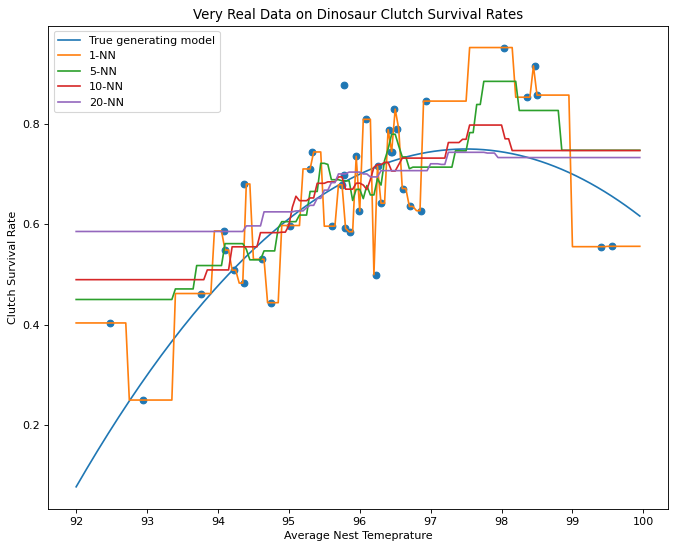

In [11]:
from sklearn.neighbors import KNeighborsRegressor

kneigh_reg_1=KNeighborsRegressor(n_neighbors=1)
kneigh_reg_5=KNeighborsRegressor(n_neighbors=5)
kneigh_reg_10=KNeighborsRegressor(n_neighbors=10)
kneigh_reg_20=KNeighborsRegressor(n_neighbors=20)


kneigh_reg_1.fit(pd_reg_x,pd_reg_y)
kneigh_reg_5.fit(pd_reg_x,pd_reg_y)
kneigh_reg_10.fit(pd_reg_x,pd_reg_y)
kneigh_reg_20.fit(pd_reg_x,pd_reg_y)

#Plot 2 models and the truth
fig,ax=plt.subplots(figsize=(10, 8), dpi=80)

ax.scatter(reg_x,reg_y)
ax.set_ylabel("Clutch Survival Rate")
ax.set_xlabel("Average Nest Temeprature")
ax.set_title("Very Real Data on Dinosaur Clutch Survival Rates")

plt.plot(reg_x_true,reg_y_true,label="True generating model")
plt.plot(reg_x_true,kneigh_reg_1.predict(pd_reg_x_predict),label="1-NN")
plt.plot(reg_x_true,kneigh_reg_5.predict(pd_reg_x_predict),label="5-NN")
plt.plot(reg_x_true,kneigh_reg_10.predict(pd_reg_x_predict),label="10-NN")
plt.plot(reg_x_true,kneigh_reg_20.predict(pd_reg_x_predict),label="20-NN")

plt.legend()
plt.show()

### Questions

* Where do the predictions of the K-NN models seem particularly bad?

### Answers

* At the edges. This is due to the fact that K-NN can only use information from one side of the x-axis and thus has no information about what is happening on the other side.